## DAT_12_SF Midterm
____________________--

### About the data
For this midterm, you'll be working with a dataset related to classifying emails as spam. The dataset was built by researchers at the UCI Machine Learning Institute

Data Set Information:

The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography... 



Attribute Information:

The last column of 'spambase.data' denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. Most of the attributes indicate whether a particular word or character was frequently occuring in the e-mail. The run-length attributes (55-57) measure the length of sequences of consecutive capital letters. 

###Definitions of the attributes: 
_______________-

####48 continuous real [0,100] attributes of type word_freq_WORD 
= percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string. 

####6 continuous real [0,100] attributes of type char_freq_CHAR] 
= percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail 

####1 continuous real [1,...] attribute of type capital_run_length_average 
= average length of uninterrupted sequences of capital letters 

####1 continuous integer [1,...] attribute of type capital_run_length_longest 
= length of longest uninterrupted sequence of capital letters 

####1 continuous integer [1,...] attribute of type capital_run_length_total 
= sum of length of uninterrupted sequences of capital letters 
= total number of capital letters in the e-mail 

####1 nominal {0,1} class attribute of type spam 
= denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. 

In [83]:
%reset -f

In [140]:
%matplotlib inline

#IMPORT LIBRARIES

from __future__ import division

import numpy as np

import pandas as pd
from pandas.tools.plotting import scatter_matrix, table, andrews_curves

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import neighbors, datasets, feature_selection, linear_model
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, normalize, binarize
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.utils import shuffle
import patsy
from patsy import dmatrices

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',60)
pd.set_option('display.precision', 2)

In [85]:
# Load the spambase.csv as a pandas DataFrame (last column of data contains Target Data - is_spam)
spam_data = pd.read_csv("/Users/rockyroxana/Science/ga/ga_sandbox/midterm/spambase.csv")

###Exercise 1: Explore the dataset and display some visualizations showing how the variables relate to each other


In [86]:
#spam_data.head(3)
#spam_data.columns
#spam_data.info
spam_data.shape #-- (4601,58)
#len(spam_data) -- 4601
#spam_data.describe().T.sort_index(by = 'max', ascending=False)
#spam_data.isnull().sum()
#spam_data.idxmax(axis=0)#.order(ascending=False)
#spam_data.dtypes

(4601, 58)

In [87]:
attributes = spam_data.iloc[:,:-1]
spam = spam_data.get('is_spam')

att_val = attributes.values
spam_val = spam.values
att_names = spam_data.columns.values[:-1]

#attributes.shape -- (4601, 57)
#spam.shape -- (4601,)


Spam Value Counts
0    2788
1    1813
dtype: int64


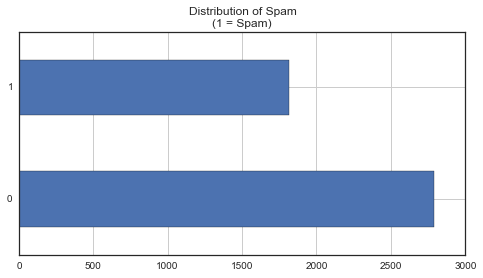

In [88]:
#Bar Chart of Spam Value Counts

fig = plt.figure(figsize=(8,4))
    
spam.value_counts().plot(kind='barh')
plt.title("Distribution of Spam\n(1 = Spam)")
print("\nSpam Value Counts\n%s"%(spam.value_counts()))

## Intuition always wants me to make a correlation matrix.

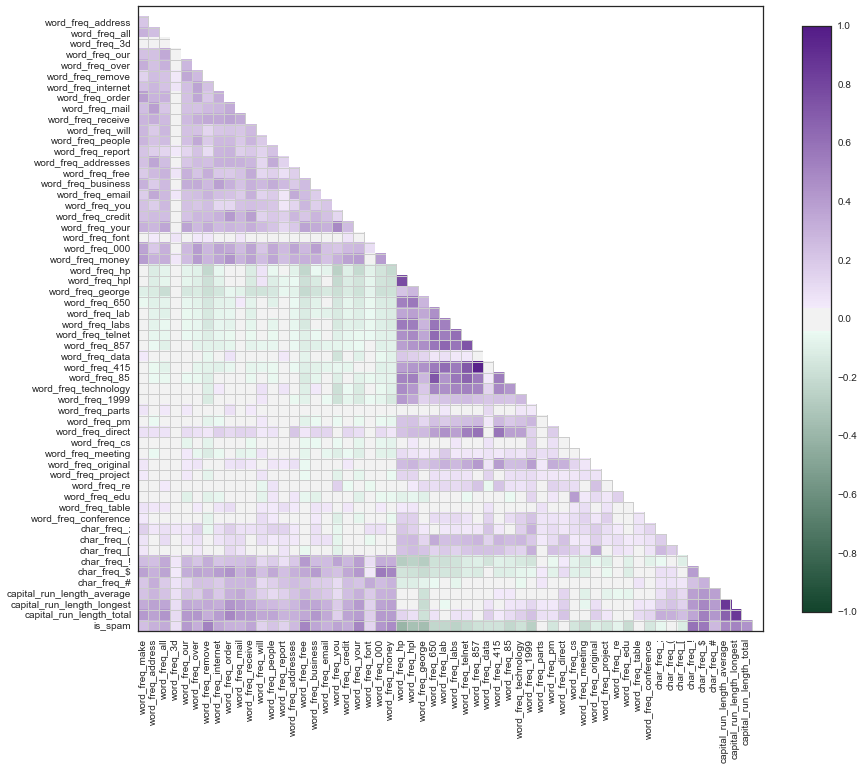

In [89]:
sns.set("notebook", style="white")

cmap = sns.diverging_palette(145, 280, s=85, l=25, n=7, as_cmap=True)
f, ax = plt.subplots(figsize=(14, 14))
sns.corrplot(spam_data, ax=ax, sig_stars=False,diag_names=False,annot=False, method='spearman',cmap=cmap)

###I'm interested in looking at which attributes are most and least correlated with spam. I computed correlations using both the spearman and person methods. Spearman is better for rank data and pearson is better for continuous, real data. 

In [90]:
#most correlated, using spearman's method.
s_corr = spam_data.corr(method='spearman')
s_corr_top = s_corr[s_corr['is_spam'] > 0]
s_corr_top.is_spam.order(ascending=False).head(6)

is_spam                       1.0
char_freq_!                   0.6
char_freq_$                   0.6
word_freq_remove              0.5
capital_run_length_longest    0.5
word_freq_free                0.5
Name: is_spam, dtype: float64

In [91]:
#least correlated, using spearman's method.
s_corr_low = s_corr[s_corr['is_spam'] < 0]
s_corr_low.is_spam.order().head(6)

word_freq_hp       -0.4
word_freq_george   -0.4
word_freq_hpl      -0.3
word_freq_1999     -0.3
word_freq_labs     -0.2
word_freq_650      -0.2
Name: is_spam, dtype: float64

In [92]:
#most correlated, using pearson's method.
p_corr = spam_data.corr(method='pearson')
p_corr_top = p_corr[p_corr['is_spam'] > 0]
p_corr_top.is_spam.order(ascending=False).head(6)

is_spam             1.0
word_freq_your      0.4
word_freq_000       0.3
word_freq_remove    0.3
char_freq_$         0.3
word_freq_you       0.3
Name: is_spam, dtype: float64

In [93]:
#least correlated, using pearsons's method.
p_corr_low = p_corr[p_corr['is_spam'] < 0]
p_corr_low.is_spam.order().head(6)

word_freq_hp       -0.3
word_freq_hpl      -0.2
word_freq_george   -0.2
word_freq_1999     -0.2
word_freq_labs     -0.2
word_freq_650      -0.2
Name: is_spam, dtype: float64

###Pearson and Spearman correlations only agree on 2 out of the 5 most signifcant attributes, while they agree on all top 5 least significant. It's likely that the spambase data set came from the emails of a person named George who worked at HP Labs in the 650, probably in 1999. (My gut tells me the Spearman results are more accurate, so I'll focus on these attributes for my initial exploration.)

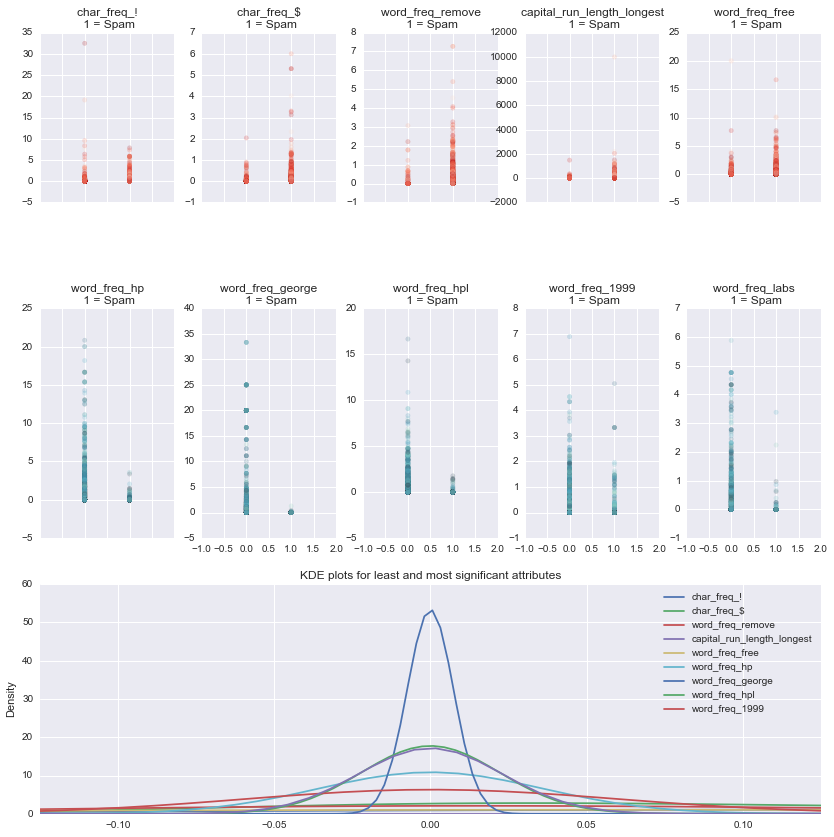

In [94]:
alpha_scatterplot = 0.2
sns.set("notebook", font_scale=1)
sns.despine(trim=True)

fig = plt.figure(figsize=(14,14))

#top 5 most significant
#char_freq_!                   0.6
#char_freq_$                   0.6
#word_freq_remove              0.5
#capital_run_length_longest    0.5
#word_freq_free                0.5

ax1 = plt.subplot2grid((4,5),(0,0))
plt.scatter(spam, spam_data['char_freq_!'], alpha=alpha_scatterplot, color = sns.color_palette("Reds"))
plt.grid(b=True, which='major',axis ='y' )  
ax1.set_xlim(-1,2)
plt.title("char_freq_! \n 1 = Spam")

ax2 = plt.subplot2grid((4,5),(0,1))
plt.scatter(spam, spam_data['char_freq_$'], alpha=alpha_scatterplot, color = sns.color_palette("Reds"))
plt.grid(b=True, which='major', axis='y')  
ax2.set_xlim(-1,2)
plt.title("char_freq_$ \n 1 = Spam")

ax3 = plt.subplot2grid((4,5),(0,2))
plt.scatter(spam, spam_data['word_freq_remove'], alpha=alpha_scatterplot, color = sns.color_palette("Reds"))
plt.grid(b=True, which='major', axis='y')  
ax3.set_xlim(-1,2)
plt.title("word_freq_remove \n 1 = Spam")

ax4 = plt.subplot2grid((4,5),(0,3))
plt.scatter(spam, spam_data['capital_run_length_longest'], alpha=alpha_scatterplot, color = sns.color_palette("Reds"))
plt.grid(b=True, which='major', axis='y')  
ax4.set_xlim(-1,2)
plt.title("capital_run_length_longest \n 1 = Spam")

ax5 = plt.subplot2grid((4,5),(0,4))
plt.scatter(spam, spam_data['word_freq_free'], alpha=alpha_scatterplot, color = sns.color_palette("Reds"))
plt.grid(b=True, which='major', axis='y')  
ax5.set_xlim(-1,2)
plt.title("word_freq_free \n 1 = Spam")

#top 5 least significant
#word_freq_hp       -0.4
#word_freq_george   -0.4
#word_freq_hpl      -0.3
#word_freq_1999     -0.3
#word_freq_labs     -0.2

ax6 = plt.subplot2grid((3,5),(1,0))
plt.scatter(spam, spam_data['word_freq_hp'], alpha=alpha_scatterplot, color = sns.color_palette("GnBu_d"))
plt.grid(b=True, which='major', axis='y')  
ax6.set_xlim(-1,2)
plt.title("word_freq_hp \n 1 = Spam")

ax7 = plt.subplot2grid((3,5),(1,1))
plt.scatter(spam, spam_data['word_freq_george'], alpha=alpha_scatterplot, color = sns.color_palette("GnBu_d"))
plt.grid(b=True, which='major', axis='y')  
ax7.set_xlim(-1,2)
plt.title("word_freq_george \n 1 = Spam")

ax8 = plt.subplot2grid((3,5),(1,2))
plt.scatter(spam, spam_data['word_freq_hpl'], alpha=alpha_scatterplot, color = sns.color_palette("GnBu_d"))
plt.grid(b=True, which='major', axis='y')  
ax8.set_xlim(-1,2)
plt.title("word_freq_hpl \n 1 = Spam")

ax9 = plt.subplot2grid((3,5),(1,3))
plt.scatter(spam, spam_data['word_freq_1999'], alpha=alpha_scatterplot, color=sns.color_palette("GnBu_d"))
plt.grid(b=True, which='major', axis='y')  
ax9.set_xlim(-1,2)
plt.title("word_freq_1999 \n 1 = Spam")

ax10 = plt.subplot2grid((3,5),(1,4))
plt.scatter(spam, spam_data['word_freq_labs'], alpha=alpha_scatterplot, color=sns.color_palette("GnBu_d"))
plt.grid(b=True, which='major', axis='y')  
ax10.set_xlim(-1,2)
plt.title("word_freq_labs \n 1 = Spam")

ax11 = plt.subplot2grid((3,5),(2,0), colspan= 5)
spam_data['char_freq_!'][spam_data.is_spam==1].plot(kind='kde')
spam_data['char_freq_$'][spam_data.is_spam==1].plot(kind='kde')
spam_data['word_freq_remove'][spam_data.is_spam==1].plot(kind='kde')
spam_data['capital_run_length_longest'][spam_data.is_spam==1].plot(kind='kde')
spam_data.word_freq_free[spam_data.is_spam==1].plot(kind='kde')
spam_data['word_freq_hp'][spam_data.is_spam==1].plot(kind='kde')
spam_data['word_freq_george'][spam_data.is_spam==1].plot(kind='kde')
spam_data.word_freq_hpl[spam_data.is_spam==1].plot(kind='kde')
spam_data['word_freq_1999'][spam_data.is_spam==1].plot(kind='kde')
spam_data['word_freq_labs'][spam_data.is_spam==1].plot(kind='kde')
ax11.set_xlim(-0.125,0.125)
ax11.legend(('char_freq_!','char_freq_$','word_freq_remove', 'capital_run_length_longest', 
                'word_freq_free','word_freq_hp','word_freq_george','word_freq_hpl','word_freq_1999'),loc='best')
plt.title("KDE plots for least and most significant attributes")
f.tight_layout()

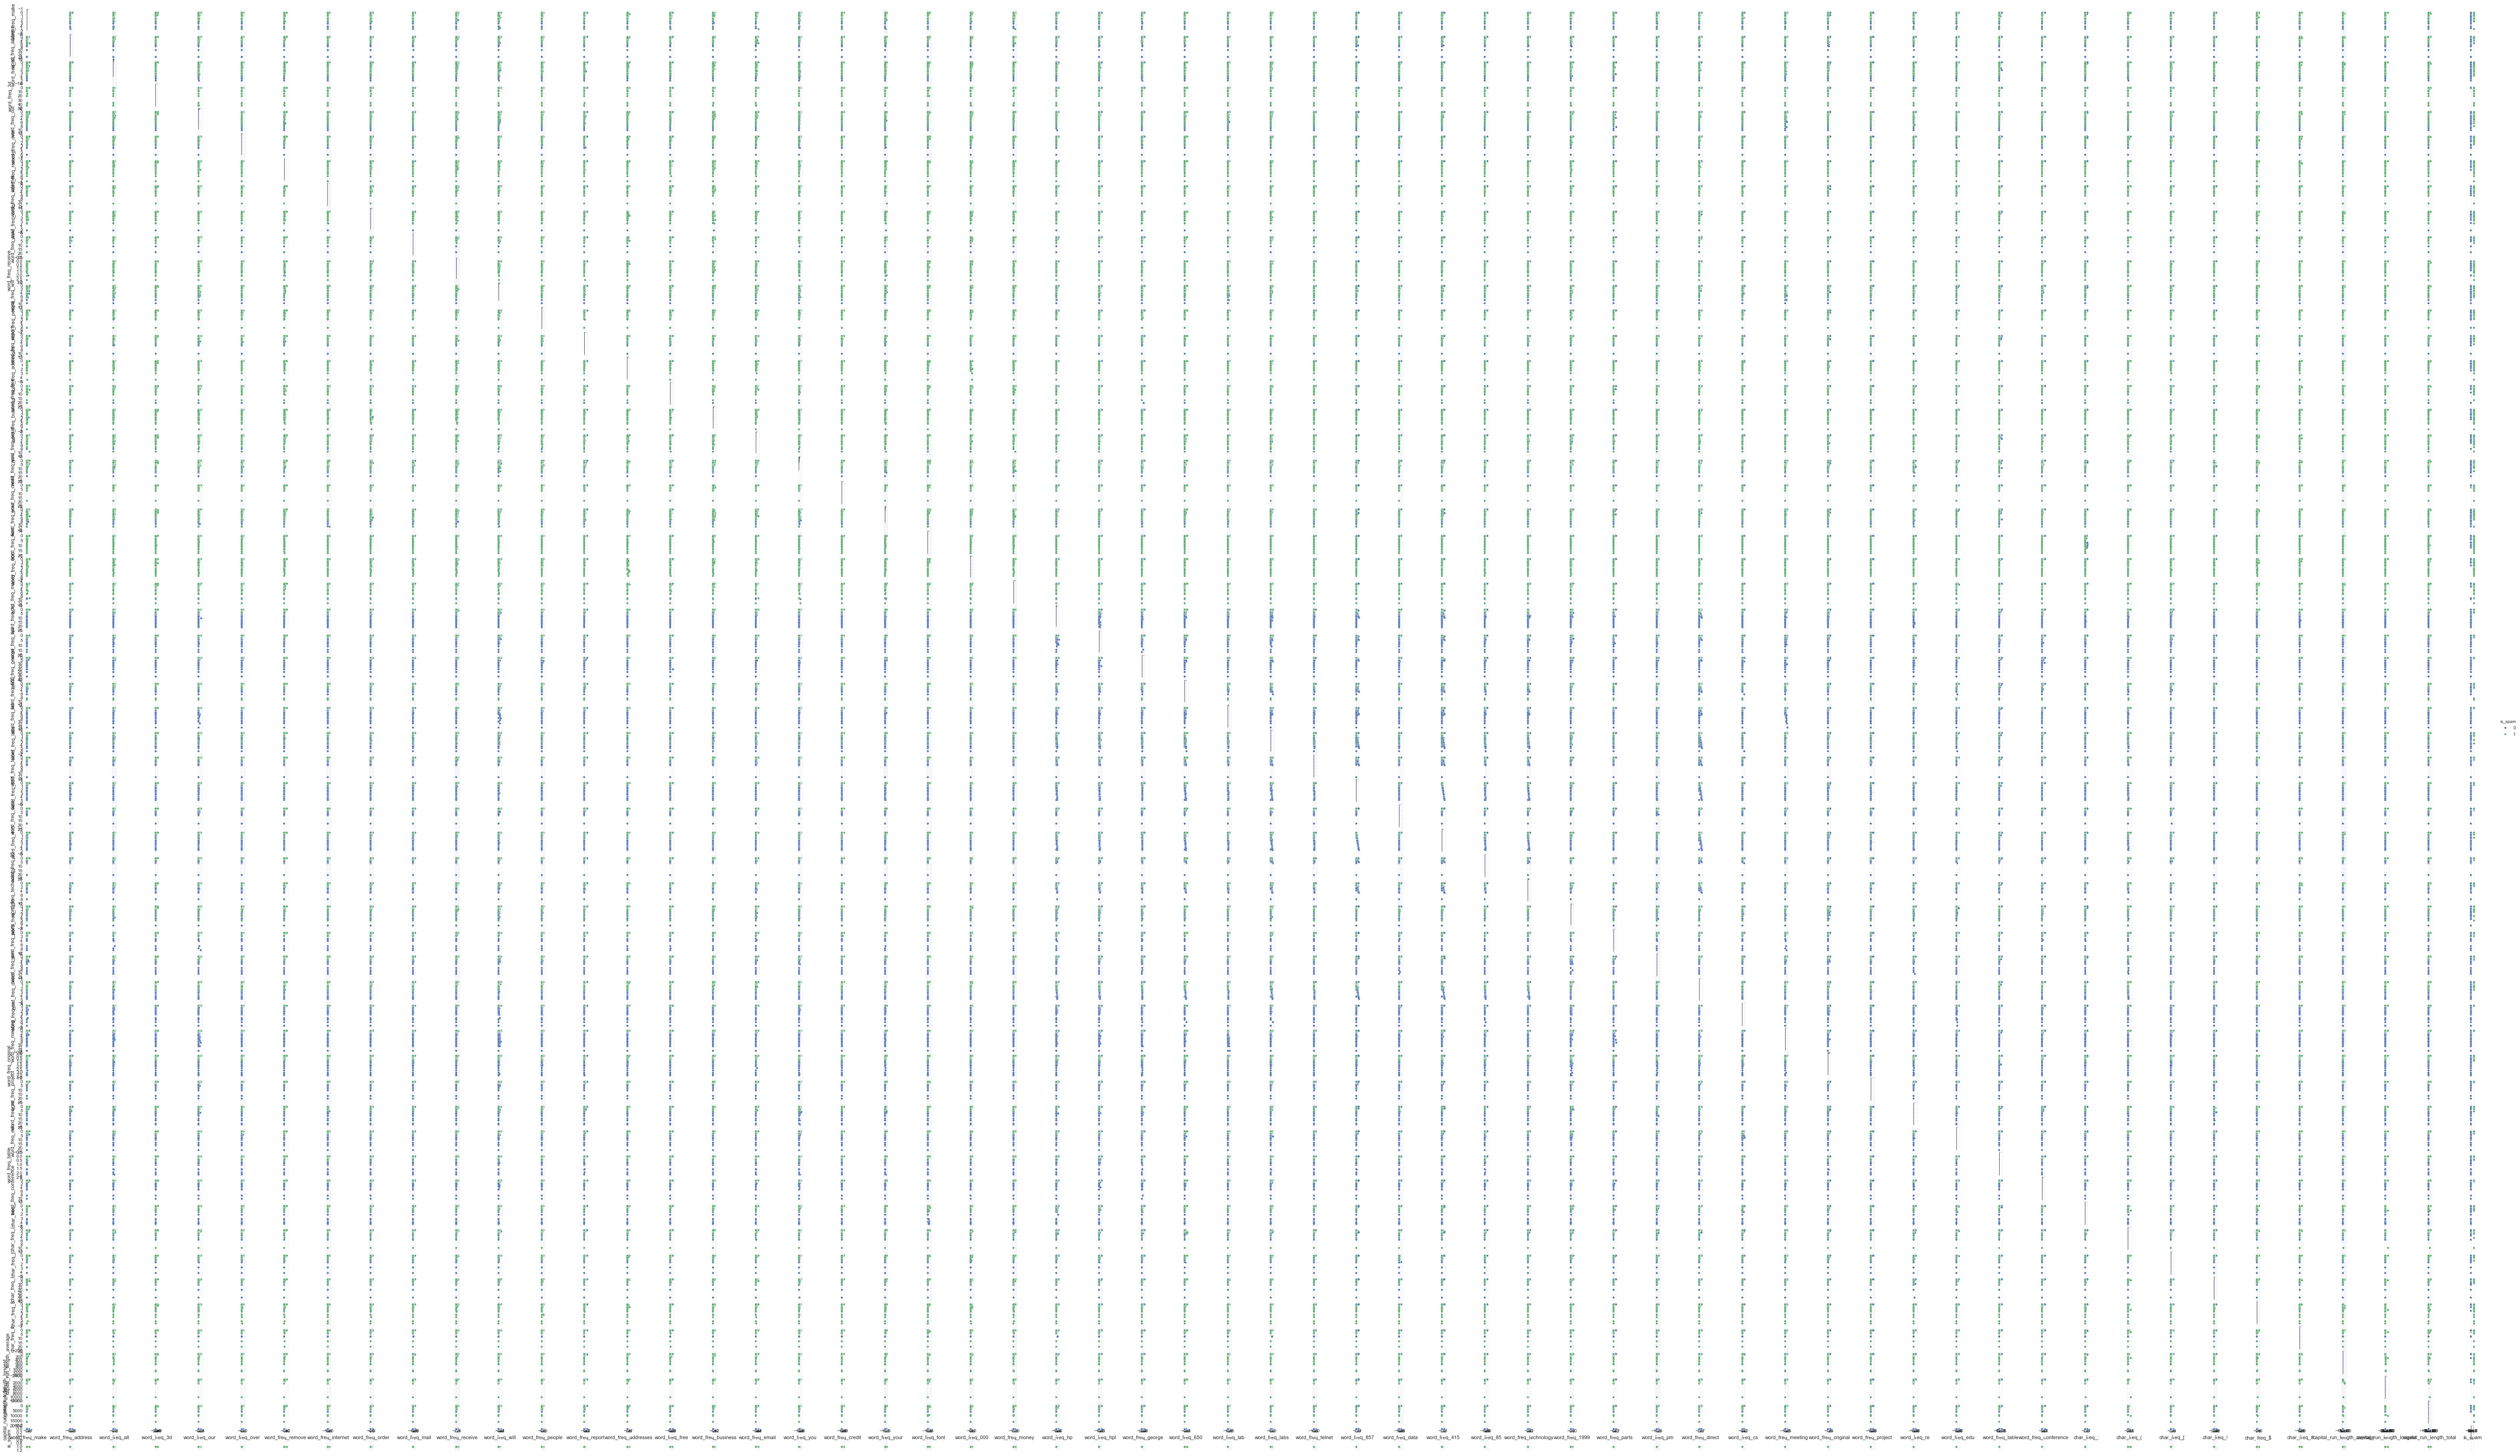

In [95]:
sns.pairplot(spam_data, kind= 'scatter', diag_kind='hist', hue="is_spam", size = 0.75, aspect=1.75)

###The massive pairplot has too much data so let just's focus on the more significant features.

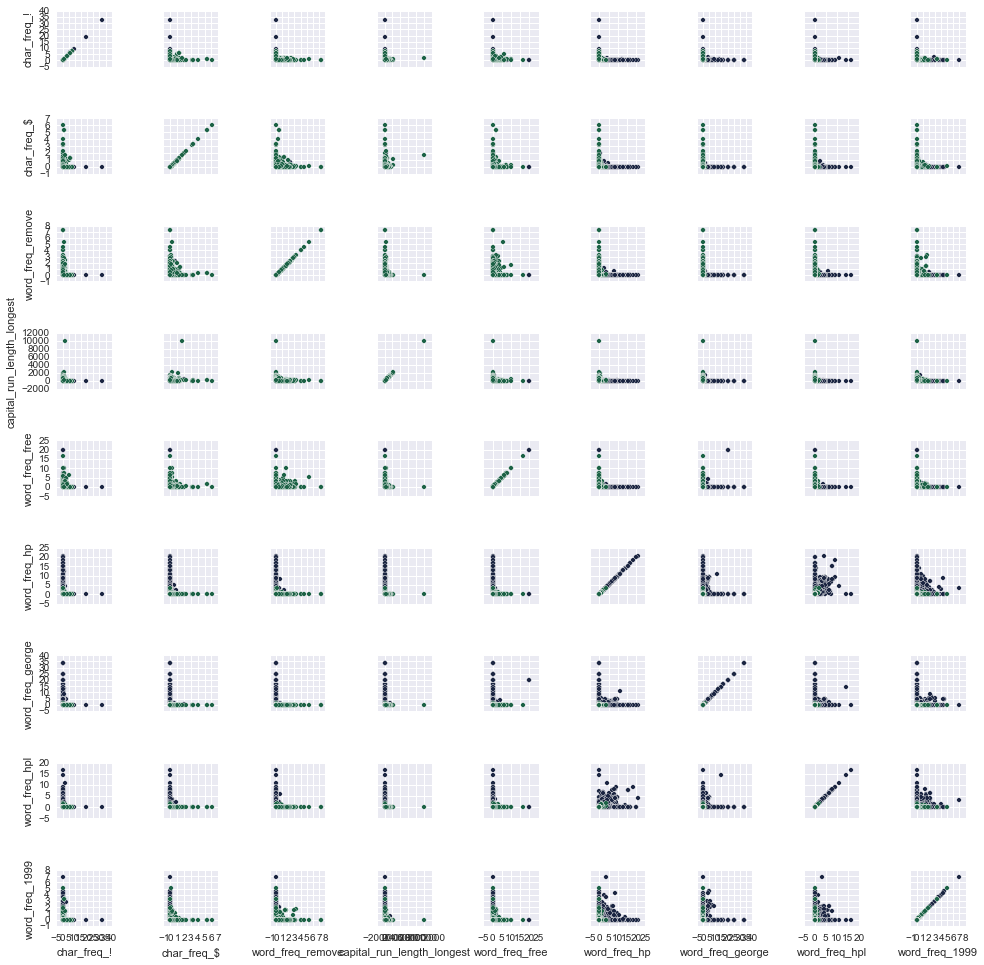

In [96]:
#pairplot of significant and insignificant features
alpha_scatterplot = 0.2
sns.set("notebook", font_scale=1, palette="cubehelix")
sns.despine(trim=True)
plt.figure(figsize=(10,10))
g = sns.PairGrid(spam_data,vars=['char_freq_!','char_freq_$','word_freq_remove', 'capital_run_length_longest', 
                'word_freq_free','word_freq_hp','word_freq_george','word_freq_hpl','word_freq_1999'],
                 hue ='is_spam',size =1.5)
g.map(plt.scatter,edgecolor="white")

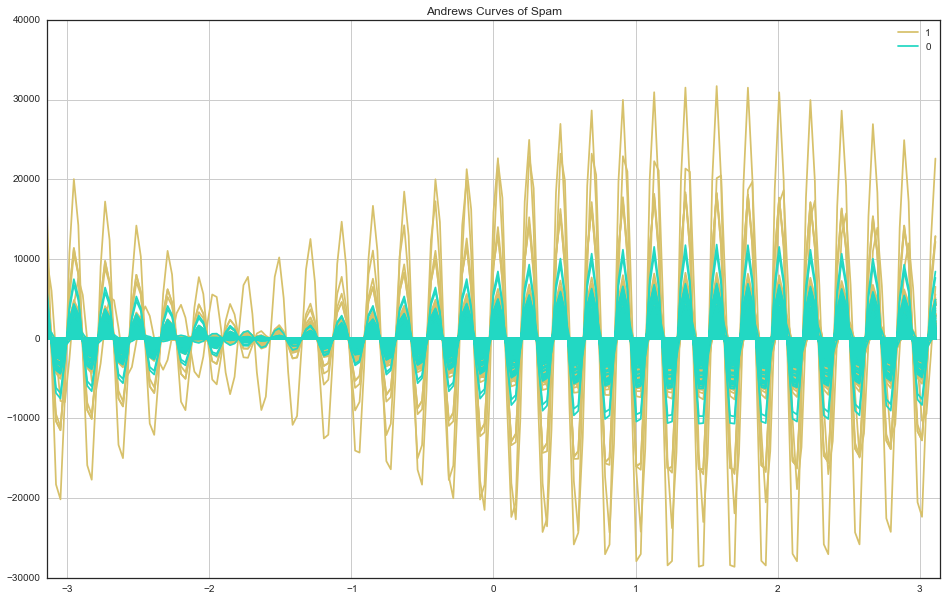

In [97]:
sns.set("notebook", style='white',font_scale=1)
plt.figure(figsize=(16,10))
andrews_curves(spam_data, 'is_spam')
plt.title("Andrews Curves of Spam")

###An Andrews curve is a way to visualize structure high-dimensional data. Above you can see the dichotomy of the number of emails that are spam (green) and not spam (yellow). Low frequency values are easier to see.

###Exercise 2: Build a simple logistic regression and visualize it

use the variable "capital_run_length_longest" to predict "is_spam"
How accurate is this single feature?

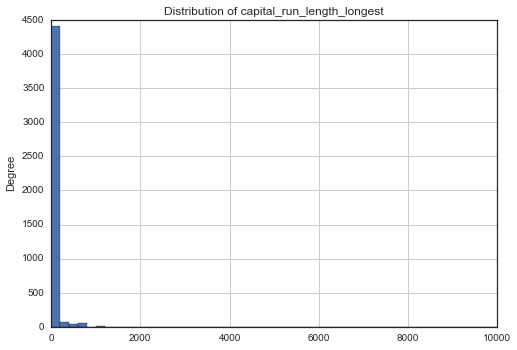

In [101]:
#Exploring the distribution of counts
attributes.capital_run_length_longest.plot(kind='hist', bins=50, xlim=(-0.5,None),
                                           title='Distribution of capital_run_length_longest')

###Crazy outlier out there are 9k! Let's change that y axis to log scale.

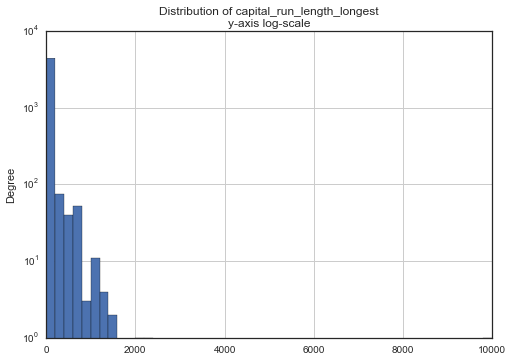

In [102]:
attributes.capital_run_length_longest.plot(kind='hist', logy=True, bins=50, xlim=(-0.5,None),
                                           title='Distribution of capital_run_length_longest\ny-axis log-scale')

In [103]:
cap_long = attributes.capital_run_length_longest
cap_long.describe()

count    4601.0
mean       52.2
std       194.9
min         1.0
25%         6.0
50%        15.0
75%        43.0
max      9989.0
Name: capital_run_length_longest, dtype: float64

###There's that outlier at max = 9989.

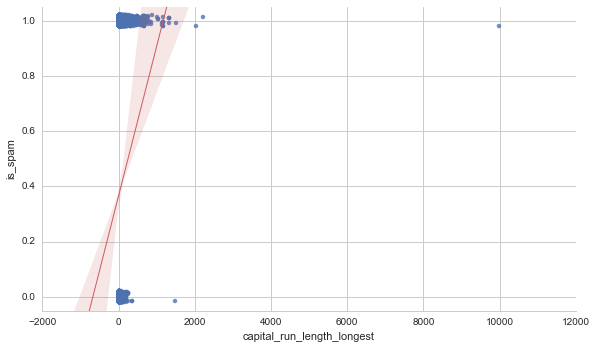

In [104]:
#LM Plot using Seaborn

alpha_scatterplot = 0.2
sns.set("notebook", font_scale=1,style="whitegrid")
sns.despine(trim=True)

g=sns.lmplot('capital_run_length_longest', 'is_spam',spam_data, ci=68, aspect=5/3, x_jitter=0.5, y_jitter=0.02,
             scatter_kws={"cmap":"BuGn_d", "edgecolor":"white"}, line_kws={"linewidth": 1, "color": "indianred"})
g.set(ylim=(-0.05,1.05), alpha=0.5)

###Alright, let's get scale out that outlier.

In [105]:
features_scalar = StandardScaler()

cap_long_scaled = features_scalar.fit_transform(attributes.capital_run_length_longest.astype(float))
attributes.capital_run_length_longest = cap_long_scaled

cap_tot_scaled= features_scalar.fit_transform(attributes.capital_run_length_total.astype(float))
attributes.capital_run_length_total = cap_tot_scaled

#attributes.dtypes

In [106]:
cap_long_model = smf.Logit(spam, attributes.capital_run_length_longest)

clm_res = cap_long_model.fit()
clm_res.summary()

Optimization terminated successfully.
         Current function value: 0.563170
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_spam   No. Observations:                 4601
Model:                          Logit   Df Residuals:                     4600
Method:                           MLE   Df Model:                            0
Date:                Fri, 13 Mar 2015   Pseudo R-squ.:                  0.1601
Time:                        00:39:59   Log-Likelihood:                -2591.1
converged:                       True   LL-Null:                       -3085.1
                                        LLR p-value:                       nan
==============================================================================================
                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
capital_run_length_longest     4.7029      0.169     27.837      0.000         4.372     5.034
==============================================================================================
"""

In [107]:
clm_res.predict(spam)[0]

0.99101213908629693

###That score seems a bit high and could be due to scaling, however, it still reasonable given the illustration of this attribute's characteristics.

### Exercise 3: Use train-test spit to split your data at a 30% mark and run another logistic regression using all variables
use random state = 12 so that we can compare results

In [108]:
att_train, att_test, spam_train, spam_test = train_test_split(att_val, spam_val, test_size=0.3, random_state=12)

In [109]:
lr_clf=LogisticRegression(C=1, penalty='l2')

lr_model = lr_clf.fit(att_train, spam_train)
spam_probs=lr_model.predict_proba(att_test)[:,1]

In [110]:
# The coefficients
print("Coefficients: \n%s\n" % (lr_model.coef_))

Coefficients: 
[[ -4.66436517e-01  -1.53885695e-01   9.83308008e-02   8.76251297e-01
    7.86281701e-01   7.63062464e-01   1.93344181e+00   4.38168580e-01
    5.10520127e-01   3.72996316e-01  -1.54058757e-02  -2.31367384e-01
   -8.14555546e-02   2.25607458e-01   5.83989059e-01   9.12061300e-01
    8.23226950e-01   9.98770417e-02   7.16649387e-02   7.22408084e-01
    3.10796308e-01   3.30473695e-01   2.10881359e+00   3.22926757e-01
   -2.13576921e+00  -8.96841096e-01  -3.30716556e+00   2.67573409e-01
   -1.50673168e+00  -7.65998491e-01  -3.71342903e-01  -2.73112526e-03
   -7.45913350e-01  -2.15790019e-01  -8.97263279e-01   7.98406261e-01
    3.50439206e-02  -5.34413487e-01  -5.90884786e-01  -1.63039422e-01
   -1.21737934e+00  -1.92395003e+00  -6.37935247e-01  -1.43615423e+00
   -7.30111442e-01  -1.78539737e+00  -1.05958525e+00  -1.46352297e+00
   -1.30004535e+00  -3.36018730e-02  -4.38216653e-01   2.60213012e-01
    4.17678813e+00   1.26952306e+00  -1.04739428e-02   6.71206849e-03
    5

In [114]:
spam_score = lr_model.decision_function(att_train)
spam_score

array([-0.57823152, -1.48293591, -3.48020228, ..., -6.58329471,
       -5.98907217, -0.18124745])

###Exercise 4: Apply Crossvalidation to see how the model fares across different splits of your date

#### Use crossvalidation to score model

In [111]:
scores = cross_val_score(lr_clf, att_train, spam_train, cv=5)

print("\nScores: %s\n"%(scores))      
print("Accuracy: %0.6f (+/- %0.6f)\n" % (scores.mean(), scores.std() * 2))


Scores: [ 0.93023256  0.92093023  0.92701863  0.93001555  0.91446345]

Accuracy: 0.924532 (+/- 0.012103)



In [112]:
scores = cross_val_score(lr_clf, att_train, spam_train, cv=10)

print("\nScores: %s\n"%(scores))      
print("Accuracy: %0.6f (+/- %0.6f)\n" % (scores.mean(), scores.std() * 2))


Scores: [ 0.92260062  0.93188854  0.93498452  0.91304348  0.89440994  0.94720497
  0.94720497  0.91900312  0.91588785  0.92211838]

Accuracy: 0.924835 (+/- 0.030625)



In [127]:
scores = cross_val_score(lr_clf, att_train, spam_train, cv=20)

print("\nScores: %s\n"%(scores))      
print("Accuracy: %0.6f (+/- %0.6f)\n" % (scores.mean(), scores.std() * 2))


Scores: [ 0.93209877  0.91358025  0.93209877  0.93209877  0.91975309  0.94444444
  0.90740741  0.91304348  0.89440994  0.88198758  0.96273292  0.94409938
  0.95031056  0.93125     0.90625     0.925       0.9         0.9125
  0.93125     0.90625   ]

Accuracy: 0.922028 (+/- 0.039346)



###That score is good. Varying cv doesn't improve much.

### Exercise 5: Compare Performance of Logistic Regression to KNN with 3 neighbors
-Which model is more accurate?

In [115]:
# Do a KNN with Three Class levels
from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(3, weights='uniform')
knn_model = clf.fit(att_train, spam_train)

In [116]:
scores = cross_val_score(clf, att_train, spam_train, cv=5)

print("\nScores: %s\n"%(scores))      
print("Accuracy: %0.6f (+/- %0.6f)\n" % (scores.mean(), scores.std() * 2))


Scores: [ 0.8124031   0.79844961  0.77950311  0.83048212  0.78227061]

Accuracy: 0.800622 (+/- 0.038136)



###Not terrible but not as good as the logit model. 

### Exercise 6: Evaluate Feature Importance
Which features are the most influential in this model?

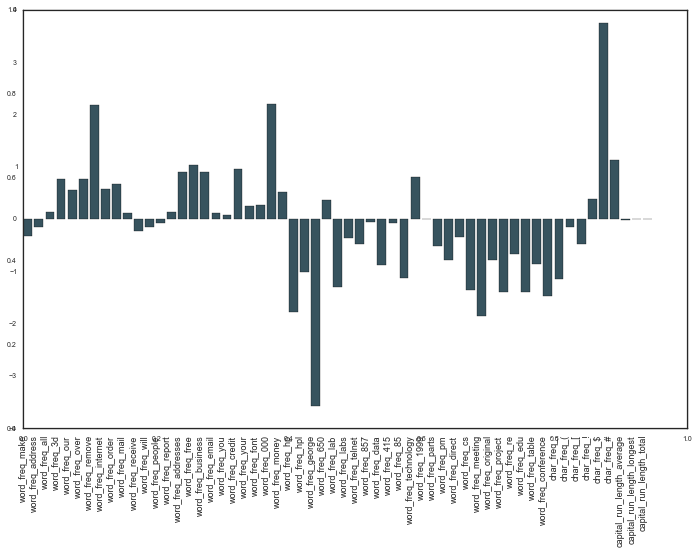

In [117]:
alpha_scatterplot = 0.2
sns.set("notebook", font_scale=0.7,palette="GnBu_d", style="white")
sns.despine(top=True, right=True,trim=True)

#using lr model
fig, ax = plt.subplots(figsize=(10,8))
ax = fig.add_subplot(111)

lr_model = lr_clf.fit(att_val, spam_val)
x = np.arange(len(att_names))
plt.bar(x, lr_model.coef_.ravel())

xtickNames = ax.set_xticklabels(att_names, rotation=90, fontsize=9)
_ = plt.xticks(x, att_names)
fig.tight_layout()

###This bar chart agrees with the correlation analysis I performed above.

### Exercise 7: Plot the ROC Curve for the logistic regression you chose

In [128]:
def plot_roc_curve(target_test, target_predicted_proba, categories):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    
    for pos_label, category in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, pos_label], pos_label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} ROC curve (area = {:.3f})'.format(category, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--', label='Luck')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

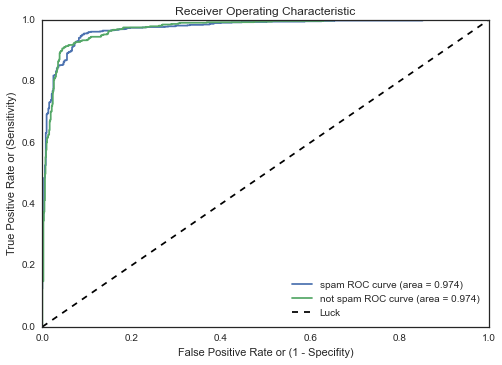

In [130]:
sns.set_context("notebook")
target_predicted_proba = lr_model.predict_proba(att_test)
target_predicted_proba.shape
plot_roc_curve(spam_test, target_predicted_proba, ['spam','not spam'])

### Exercise 8: Demonstrate how the accurary of your predictions changes when you set your threshold to levels other than 50%

###Below I tried to plot a precision-recall curve, but had trouble executing. I figured I'd share the attempt. I believe my response to this exercise is the same as in number 9. I'm not sure how else to illutrate.

In [149]:
def plot_pr_curve(target_test, target_predicted_proba, categories):
    
    for pos_label, category in enumerate(['spam','not spam']):
        precision, recall = precision_recall_curve(target_test, target_predicted_proba)
        average_precision = average_precision_score(target_test, target_predicted_proba[:, pos_label])
        plt.plot(fpr, tpr, label='{} ROC curve (area = {:.3f})'.format(category, roc_auc))
    
    plt.clf()
    plt.plot(recall,precision, label='Precision-Recall curve')
    #plt.plot([0, 1], [0, 1], 'k--', label='Luck')  # random predictions curve
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
    plt.legend(loc="lower left")
    plt.show()

In [150]:
plot_pr_curve(spam_test,spam_probs, ['spam','not spam'])

ValueError: too many values to unpack

In [144]:
precision, recall, thresholds =precision_recall_curve(spam_test, spam_probs)#, pos_label=None, sample_weight=None)
precision, recall, thresholds

(array([ 0.47818182,  0.47770701,  0.47814208, ...,  1.        ,
         1.        ,  1.        ]),
 array([ 1.        ,  0.99809886,  0.99809886, ...,  0.00760456,
         0.00570342,  0.        ]),
 array([  6.88649092e-04,   7.05882172e-04,   7.34888268e-04, ...,
          9.99999413e-01,   9.99999920e-01,   1.00000000e+00]))

###Exercise 9: Discuss the pro's/con's of moving the threshold away from 50%, why is/isn't this a good idea? 

##A ROC curve (and the area under it) illustrates the precision-recall tradeoff as the classification threshold is varied. By default in a binary classification task, if your classifier's score is  > 0.5, then class1 is predicted, otherwise class0 is predicted. As you change that threshold, you get a curve like this. The higher up the curve is (more area under it), the better that classifier. However, to get this curve you need access to the scores of a classifier, not its decisions. Otherwise whatever the decision threshold is, the decision stay the same, and AUC degenerates to accuracy.

[[817  38]
 [ 53 473]]


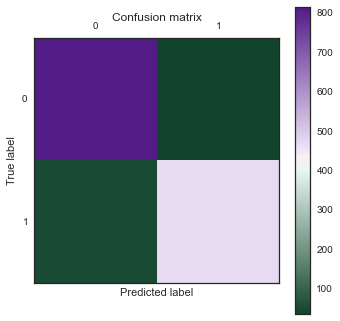

In [118]:
sns.set("notebook", style="white")

cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7, as_cmap=True)

# Compute confusion matrix
cm=confusion_matrix(spam_test, lr_model.predict(att_test))

print(cm)
# Show confusion matrix in a separate window
plt.matshow(cm, cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
plt.colormaps()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###Confusion matrix illustrates that, in the test data, 817 emails were accurately predicted (true positives), 38 were false positives, 53 werefalse negatives, and 473 were true negatives.

###Bonus: Apply PCA to the features and visualize the data in two dimensions: 

#Wish I could. I'll do it this weekend. :)